Welcome to my final project for DTSA 5510: Unsupervised Algorithms in Machine Learning! For this project, I’ll be working with a dataset that I’ve been compiling over the last few months.

I’m a big golf fan and currently work at a golf simulator location, where we have the ability to track detailed data on every shot taken. Using this system, I’ve recorded approximately 1,100 of my own golf shots across 9 different clubs. Each shot captures 22 unique metrics, including data like ball speed, spin rate, launch angle, club path, and many others. I aimed to collect around 120 swings for each club to ensure a balanced and representative sample. This dataset is deeply personal and meaningful to me, and I hope it can serve as a foundation for insights not just into my game, but potentially as a tool for other golfers in the future.

This project centers on an unsupervised learning problem: I do not have predefined labels for each shot (such as “pure strike” or “mishit”), but I believe there are meaningful patterns within the data that can be discovered through machine learning. I plan to use Principal Component Analysis (PCA) and K-means Clustering to reduce dimensionality and identify clusters of similar shots. These clusters may reveal shot types—such as well-struck shots, off-center hits, or unusually high-spin shots—and can give insight into my swing tendencies, consistency, and areas for improvement.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
 # Importing dataset
golf_data = pd.read_csv("fresh_golf_data.csv", encoding="utf-8-sig", skiprows=3)
pd.set_option('display.max_columns', None)
golf_data.head()

,﻿Shot Number,Club Name,Club Type,Shot Created Date,Ball Speed (mph),Push/Pull (deg L-/R+),Launch Angle (deg),Back Spin (rpm),Side Spin (rpm L-/R+),Total Spin (rpm),Carry (yds),Total Distance (yds),Offline (yds L-/R+),Peak Height (yds),Descent Angle (deg),Club Speed (mph),Club Speed at Impact Location (mph),Efficiency,Angle of Attack (deg),Club Path (deg out-in-/in-out+),Face to Target (deg closed-/open+),Lie (deg toe down-/toe up+),Loft (deg),Face Impact Horizontal (mm toe-/heel+),Face Impact Vertical (mm low-/high+),Closure Rate (deg/sec)
0,1,7i,Iron,06/15/2025 01:04:40,111.8,0.2,20.8,5609,39,5609,153.7,165.9,1.3,31.7,47.7,83.6,85.0,1.33,-2.2,0.7,0.1,1.9,29.2,-8,-7,2557.7
1,2,7i,Iron,06/15/2025 01:06:26,111.8,0.8,19.2,5879,246,5884,153.7,165.9,5.9,29.6,46.4,85.0,87.2,1.31,-4.3,0.2,-0.2,1.7,26.9,-15,-11,2498.2
2,3,7i,Iron,06/15/2025 01:06:54,109.6,1.2,19.5,5384,-18,5384,153.1,165.7,3.2,29.0,45.8,85.3,85.0,1.29,-3.3,2.2,1.5,3.0,27.7,18,-14,2466.0
3,4,7i,Iron,06/15/2025 01:07:26,107.4,-0.3,17.1,5965,343,5975,147.9,159.7,3.8,24.8,43.1,84.6,85.0,1.28,-4.1,0.1,-0.6,2.5,26.3,-2,-21,2778.9
4,5,7i,Iron,06/15/2025 01:07:52,114.1,0.3,19.3,6069,-42,6069,157.3,169.3,0.4,31.6,47.5,86.1,87.2,1.32,-3.2,1.0,-0.4,3.5,27.6,-2,-16,2171.9


EXPLORATORY DATA ANALYSIS
So here is the first look at our dataset. You can see for each row we have many columns.
For those unfamiliar with golf, let me describe some of the columns that are not straight forward.

Push/Pull (deg L-/R+): The horizontal starting direction of the ball relative to the target. A push will start right of the target and have a positive value. Pulls start to the left and will have a negative value.

Launch Angle (deg): The angle at which the ball leaves the clubface relative to the ground.

Carry (yds): The distance the ball travels in the air before touching the ground (This metric does not include roll out, that is what total distance is)

Offline (yds L-/R+): How far left or right of hte target the ball lands. Negative values are left of target and positive values are right.

Descent Angle (deg): The angle at which the ball is falling to the ground before landing.

Efficiency: A ratio of ball speed divided by club speed. AKA Smash Factor

Angle of Attack (deg):The vertical direction the clubhead is moving at impact. Positive numbers mean that the club is hitting up on the ball, and negatives mean the club is hitting down on the ball.

Club Path (deg out-in/ in-out): the direction the clubhead is moving horizontally at impact. Negatives here mean an "out-to-in" path, positives mean an "in-to-out" path.

Face to Target (deg closed-/open+): This is the angle of the clubface relative to the target at impact. An open face will see positive values amd a closed face will have negative values.

Lie(deg toe down-/ toe up+): The angle of the club's sole at impact. Toe down will have negative numbers and toe up will see positive numbers.

Loft(deg): The vertical angle of the clubface at impact

Face Impact Horizontal (mm toe-/heel+): Where the ball is struck on the club face side to side. Strikes near the toe will have negative values and heel strikes will hae positive values.

Face Impact Verical (mm low-/high+): Exactly the same as the previous metric only this measures from high to low rather than side to side. Low strikes will be negative and high strikes will be positive

Closure Rate (deg/sec): How quickly the clubface is rotating at impact.

Now that everyone is on the same page. Let's get to inspecting and cleaning our data

In [3]:
total_shots = len(golf_data)
club_counts = golf_data['Club Name'].value_counts()
print(f"Total number of shots recorded: {total_shots}")
print(club_counts)

Total number of shots recorded: 1159
Club Name
Dr        123
9i        121
7i        120
8i        120
5i        120
6i        120
4h        115
PW        113
3w        113
Putter     66
GW         15
LW          6
4i          4
SW          2
2h          1
Name: count, dtype: int64


We can see that there are more than the 9 clubs that I stated before, but I expected this as sometimes my warm ups with some clubs like GW, LW, and, SW were recorded in addition to plenty of putter shots that I know weren't putter as I never use that club in the simulator. I just want to quick sift through all the putter shots to make sure they are not actually mislabeled as another club. I can spot any issues by distances and if some metrics are actually tracked. We use reflective stickers on the face of each club to gather club data, but i have not done that to my wedges so they should not have some recorded metrics.

All the putter data can be pulled out of the set in addition to all the wedge shots. 

In [4]:
golf_data = golf_data[golf_data["Club Type"] != "Putter"]
golf_data = golf_data[golf_data["Club Name"] != "GW"]
golf_data = golf_data[golf_data["Club Name"] != "SW"]
golf_data = golf_data[golf_data["Club Name"] != "LW"]
total_shots = len(golf_data)
print(f"Total number of shots recorded: {total_shots}")

Total number of shots recorded: 1070


Alright, we are down to 1070, but we are not finished cleaning. I wanted to inspect the 4 4i shots and the 1 2h shot as I believe these are simply mislabeled.


In [5]:
clubs_to_check = ['4i', '2h']
suspect_shots = golf_data[golf_data['Club Name'].isin(clubs_to_check)]
suspect_shots

,﻿Shot Number,Club Name,Club Type,Shot Created Date,Ball Speed (mph),Push/Pull (deg L-/R+),Launch Angle (deg),Back Spin (rpm),Side Spin (rpm L-/R+),Total Spin (rpm),Carry (yds),Total Distance (yds),Offline (yds L-/R+),Peak Height (yds),Descent Angle (deg),Club Speed (mph),Club Speed at Impact Location (mph),Efficiency,Angle of Attack (deg),Club Path (deg out-in-/in-out+),Face to Target (deg closed-/open+),Lie (deg toe down-/toe up+),Loft (deg),Face Impact Horizontal (mm toe-/heel+),Face Impact Vertical (mm low-/high+),Closure Rate (deg/sec)
486,15,4i,Iron,04/11/2025 18:25:10,91.7,1.0,27.4,7989,-404,7999,114.5,122.7,281.1,28.2,50.1,77.7,78.3,1.18,-3.8,3.2,-1.1,1.1,39.8,-13,-10,2196.6
650,1,4i,Iron,03/25/2025 01:46:02,89.5,1.1,21.0,7172,829,7220,110.8,120.0,310.9,19.2,42.0,77.8,78.3,1.14,-4.5,2.1,2.0,1.5,40.7,11,-26,1839.6
823,64,4i,Iron,03/21/2025 17:24:54,123.0,3.8,6.7,4274,-14,4274,168.8,186.3,12.1,13.4,27.4,88.1,91.7,1.40,-0.3,0.2,0.3,1.1,22.3,-20,-17,2287.4
848,17,4i,Iron,03/11/2025 01:15:51,82.8,2.1,31.8,8007,-447,8019,96.6,103.2,328.8,26.1,51.4,75.6,73.8,1.08,-1.9,4.6,1.3,1.3,46.2,18,-15,1992.3
934,1,2h,Hybrid,03/09/2025 00:33:14,85.0,-0.7,26.8,7802,204,7805,104.2,111.7,321.8,23.5,47.7,76.0,76.1,1.12,-2.7,1.9,-0.4,2.6,41.9,12,-20,1675.6


So I can already tell that these shots belong in the set somewhere as they all have full data metrics recorded. Shots 486, 650, 848, and 934 I believe are actually Pitching Wedges as they have similar club speed and distances. However, I'm a bit stumped on shot 823. Looking that the impact location I can tell whatever club it was was struck extremely poorly. Initialy I was thinking it was a 6i, but going back through my data, the club speed did not match a 6i around that time period this shot was recorded. It would appear that this is actually a 4h after seeing simliar club speeds and loft values during this same day the shots were recorded. Let's relabel these swings to their appropriate club names.

In [6]:
golf_data['Shot Number'] = golf_data.index + 1

# golf_data.loc[golf_data['Shot Number'] == 486, 'Club Name'] = 'PW'
# golf_data.loc[golf_data['Shot Number'] == 650, 'Club Name'] = 'PW'
# golf_data.loc[golf_data['Shot Number'] == 848, 'Club Name'] = 'PW'
# golf_data.loc[golf_data['Shot Number'] == 934, 'Club Name'] = 'PW'
# golf_data.loc[golf_data['Shot Number'] == 823, 'Club Name'] = '4h'

golf_data.loc[486, 'Club Name'] = 'PW'
golf_data.loc[486, 'Club Type'] = 'Wedge'
golf_data.loc[650, 'Club Name'] = 'PW'
golf_data.loc[650, 'Club Type'] = 'Wedge'
golf_data.loc[848, 'Club Name'] = 'PW'
golf_data.loc[848, 'Club Type'] = 'Wedge'
golf_data.loc[934, 'Club Name'] = 'PW'
golf_data.loc[934, 'Club Type'] = 'Wedge'
golf_data.loc[823, 'Club Name'] = '4h'
golf_data.loc[823, 'Club Type'] = 'Hybrid'

Continuing cleaning this data I made a mental note that during some of my sessions that some shots were being recorded as Driver when I was hitting an Iron. This should be easy to find as swing speeds will be drastically lower than normal Driver values.

In [7]:
suspicious_driver_shots = golf_data[
    (golf_data['Club Type'] == 'Driver') & 
    (golf_data['Club Speed (mph)'] < 90)
]

suspicious_driver_shots.head(20)

,﻿Shot Number,Club Name,Club Type,Shot Created Date,Ball Speed (mph),Push/Pull (deg L-/R+),Launch Angle (deg),Back Spin (rpm),Side Spin (rpm L-/R+),Total Spin (rpm),Carry (yds),Total Distance (yds),Offline (yds L-/R+),Peak Height (yds),Descent Angle (deg),Club Speed (mph),Club Speed at Impact Location (mph),Efficiency,Angle of Attack (deg),Club Path (deg out-in-/in-out+),Face to Target (deg closed-/open+),Lie (deg toe down-/toe up+),Loft (deg),Face Impact Horizontal (mm toe-/heel+),Face Impact Vertical (mm low-/high+),Closure Rate (deg/sec),Shot Number
20,21,Dr,Driver,06/15/2025 01:19:09,143.2,4.6,15.0,2451,-561,2514,0.3,260.8,0.1,34.9,8.3,5.9,6.7,1.40,20.2,6.4,-1.8,16.6,17.1,20,-10,48.9,21
187,2,Dr,Driver,04/20/2025 00:49:59,80.5,3.6,30.1,8501,564,8520,95.7,102.3,9.5,23.9,49.6,77.8,76.1,1.04,-5.7,1.8,5.7,0.5,44.6,12,-5,1948.9,188
296,15,Dr,Driver,04/15/2025 02:58:55,98.4,1.6,23.4,7008,134,7009,127.9,137.2,5.2,27.5,47.6,80.0,80.5,1.22,-4.6,2.2,1.5,1.5,33.9,3,-18,2458.5,297
405,17,Dr,Driver,04/12/2025 18:59:43,82.8,4.9,25.8,9411,1676,9559,99.5,105.9,17.6,21.4,46.8,78.3,78.3,1.06,-5.7,2.1,7.8,1.4,42.6,7,-20,1859.1,406
488,17,Dr,Driver,04/11/2025 18:26:23,87.2,-0.2,22.3,7475,535,7494,109.0,117.8,3.2,19.9,43.1,79.4,78.3,1.10,-5.1,2.4,0.8,3.2,39.9,16,-23,2057.4,489
600,2,Dr,Driver,04/01/2025 02:45:41,91.7,-1.6,26.9,7688,-147,7689,115.3,123.9,-4.6,28.0,49.8,78.2,78.3,1.18,-5.0,-0.9,-2.6,0.2,38.4,-8,-5,2169.6,601
653,4,Dr,Driver,03/25/2025 01:48:02,91.7,-0.6,27.9,7040,-455,7055,116.1,125.2,-5.1,28.9,50.0,78.3,78.3,1.18,-3.4,1.2,-3.1,0.9,40.4,0,-3,1969.7,654
1060,13,Dr,Driver,02/19/2025 03:38:49,85.0,1.7,30.2,7229,-277,7234,104.4,112.8,1.5,26.8,50.5,75.4,73.8,1.13,-1.5,3.7,0.6,1.8,42.8,16,-11,1830.6,1061
1111,64,Dr,Driver,02/19/2025 03:59:54,116.3,-2.9,15.6,1279,-567,1399,176.5,204.2,-35.2,17.6,27.2,87.8,85.0,1.32,12.1,8.8,0.7,7.1,21.1,33,-3,2257.8,1112
1114,67,Dr,Driver,02/19/2025 04:01:11,125.3,0.5,19.4,1632,-1321,2100,195.6,215.3,-52.5,28.2,38.1,89.6,89.5,1.40,7.5,5.6,-0.4,4.7,18.2,0,20,2333.5,1115


Some interesting notes from looking at this subset, one of the records indicate a shot that carried less than a yard and was swung at only 6mph, yet had a total distance of 260. not sure whats going on there but im going to throw that one out. As for the other values, some were mislabeled and some were just poor shots. So lets clean them up a bit.

In [8]:
golf_data.loc[187, 'Club Name'] = 'GW'
golf_data.loc[187, 'Club Type'] = 'Wedge'
golf_data.loc[296, 'Club Name'] = '9i'
golf_data.loc[296, 'Club Type'] = 'Iron'
golf_data.loc[405, 'Club Name'] = 'PW'
golf_data.loc[405, 'Club Type'] = 'Wedge'
golf_data.loc[488, 'Club Name'] = 'PW'
golf_data.loc[488, 'Club Type'] = 'Wedge'
golf_data.loc[600, 'Club Name'] = 'PW'
golf_data.loc[600, 'Club Type'] = 'Wedge'
golf_data.loc[653, 'Club Name'] = 'PW'
golf_data.loc[653, 'Club Type'] = 'Wedge'
golf_data.loc[1060, 'Club Name'] = 'PW'
golf_data.loc[1060, 'Club Type'] = 'Wedge'
golf_data.loc[1061, 'Club Name'] = 'PW'
golf_data.loc[1061, 'Club Type'] = 'Wedge'

golf_data = golf_data[golf_data["Club Name"] != "GW"]

golf_data = golf_data.loc[golf_data['Shot Number'] != 21]

total_shots = len(golf_data)
club_counts = golf_data['Club Name'].value_counts()
print(f"Total number of shots recorded: {total_shots}")
print(club_counts)
golf_data.dtypes

Total number of shots recorded: 1068
Club Name
PW    123
9i    122
7i    120
5i    120
6i    120
8i    120
4h    116
Dr    115
3w    112
Name: count, dtype: int64


﻿Shot Number                                int64
Club Name                                  object
Club Type                                  object
Shot Created Date                          object
Ball Speed (mph)                          float64
Push/Pull (deg L-/R+)                     float64
Launch Angle (deg)                        float64
Back Spin (rpm)                             int64
Side Spin (rpm L-/R+)                       int64
Total Spin (rpm)                            int64
Carry (yds)                               float64
Total Distance (yds)                      float64
Offline (yds L-/R+)                       float64
Peak Height (yds)                         float64
Descent Angle (deg)                       float64
Club Speed (mph)                          float64
Club Speed at Impact Location (mph)       float64
Efficiency                                float64
Angle of Attack (deg)                     float64
Club Path (deg out-in-/in-out+)           float64


Next I just want to clean up the date a bit and exclude the time and just keep the month/day/year format.

In [9]:
golf_data['Shot Created Date'] = pd.to_datetime(golf_data['Shot Created Date'], format='%m/%d/%Y %H:%M:%S')
golf_data['Shot Date'] = golf_data['Shot Created Date'].dt.strftime('%m/%d/%Y')
golf_data.drop(columns=['Shot Created Date'], inplace=True)
golf_data.head()

,﻿Shot Number,Club Name,Club Type,Ball Speed (mph),Push/Pull (deg L-/R+),Launch Angle (deg),Back Spin (rpm),Side Spin (rpm L-/R+),Total Spin (rpm),Carry (yds),Total Distance (yds),Offline (yds L-/R+),Peak Height (yds),Descent Angle (deg),Club Speed (mph),Club Speed at Impact Location (mph),Efficiency,Angle of Attack (deg),Club Path (deg out-in-/in-out+),Face to Target (deg closed-/open+),Lie (deg toe down-/toe up+),Loft (deg),Face Impact Horizontal (mm toe-/heel+),Face Impact Vertical (mm low-/high+),Closure Rate (deg/sec),Shot Number,Shot Date
0,1,7i,Iron,111.8,0.2,20.8,5609,39,5609,153.7,165.9,1.3,31.7,47.7,83.6,85.0,1.33,-2.2,0.7,0.1,1.9,29.2,-8,-7,2557.7,1,06/15/2025
1,2,7i,Iron,111.8,0.8,19.2,5879,246,5884,153.7,165.9,5.9,29.6,46.4,85.0,87.2,1.31,-4.3,0.2,-0.2,1.7,26.9,-15,-11,2498.2,2,06/15/2025
2,3,7i,Iron,109.6,1.2,19.5,5384,-18,5384,153.1,165.7,3.2,29.0,45.8,85.3,85.0,1.29,-3.3,2.2,1.5,3.0,27.7,18,-14,2466.0,3,06/15/2025
3,4,7i,Iron,107.4,-0.3,17.1,5965,343,5975,147.9,159.7,3.8,24.8,43.1,84.6,85.0,1.28,-4.1,0.1,-0.6,2.5,26.3,-2,-21,2778.9,4,06/15/2025
4,5,7i,Iron,114.1,0.3,19.3,6069,-42,6069,157.3,169.3,0.4,31.6,47.5,86.1,87.2,1.32,-3.2,1.0,-0.4,3.5,27.6,-2,-16,2171.9,5,06/15/2025


Before we conclude our data cleaning I just want to make sure there are no null or missing values

In [10]:
# Step 1: List only the numeric columns (excludes Club Name, Club Type, etc.)
numeric_cols = golf_data.select_dtypes(include='number').columns

# Step 2: Count how many 0.0 values each row has across numeric columns
golf_data['zero_count'] = (golf_data[numeric_cols] == 0.0).sum(axis=1)

# Total number of suspicious rows
num_suspicious_rows = (golf_data['zero_count'] >= 5).sum()
print(f"Total rows with 5 or more zero values: {num_suspicious_rows}")

# Filter rows that are suspicious (e.g., ≥ 5 zeros)
suspicious_rows = golf_data[golf_data['zero_count'] >= 5]

# Count of bad rows per club
club_zero_counts = suspicious_rows['Club Name'].value_counts()

# Show results
print("Count of rows with 5+ zeros by club:")
print(club_zero_counts)

Total rows with 5 or more zero values: 24
Count of rows with 5+ zeros by club:
Club Name
6i    5
7i    5
5i    4
4h    3
9i    2
3w    2
PW    2
8i    1
Name: count, dtype: int64


These are all the rows that were not recorded fully. I believe this to be due to worn reflective stickers on the club. Instead of throwing these out we will fill their values with the averages for that club.

In [11]:
# Make a copy to avoid changing the original just yet
filled_data = golf_data.copy()

# Select numeric columns (excluding 'zero_count')
numeric_cols = filled_data.select_dtypes(include='number').columns.drop('zero_count', errors='ignore')

# Dictionary to store averages
club_column_averages = []

# Fill zeros with club-specific means and collect them
for club in filled_data['Club Name'].unique():
    club_mask = filled_data['Club Name'] == club

    for col in numeric_cols:
        non_zero_mask = filled_data[col] != 0.0
        club_avg = filled_data.loc[club_mask & non_zero_mask, col].mean()

        # Replace 0.0s with average
        fill_mask = club_mask & (filled_data[col] == 0.0)
        filled_data.loc[fill_mask, col] = club_avg

        # Save the average used
        if fill_mask.sum() > 0:
            club_column_averages.append({
                "Club Name": club,
                "Metric": col,
                "Filled Average": round(club_avg, 2),
                "Filled Count": fill_mask.sum()
            })


C:\Users\preci\AppData\Local\Temp\ipykernel_14616\2070573070.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filled_data.loc[fill_mask, col] = club_avg
C:\Users\preci\AppData\Local\Temp\ipykernel_14616\2070573070.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5047.491666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filled_data.loc[fill_mask, col] = club_avg
C:\Users\preci\AppData\Local\Temp\ipykernel_14616\2070573070.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '173.91596638655463' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filled_data

In [12]:
# Step 1: List only the numeric columns (excludes Club Name, Club Type, etc.)
numeric_cols = filled_data.select_dtypes(include='number').columns

# Step 2: Count how many 0.0 values each row has across numeric columns
filled_data['zero_count'] = (filled_data[numeric_cols] == 0.0).sum(axis=1)

# Total number of suspicious rows
num_suspicious_rows = (filled_data['zero_count'] >= 5).sum()
print(f"Total rows with 5 or more zero values: {num_suspicious_rows}")

# Filter rows that are suspicious (e.g., ≥ 5 zeros)
suspicious_rows = filled_data[filled_data['zero_count'] >= 5]

# Count of bad rows per club
club_zero_counts = suspicious_rows['Club Name'].value_counts()

# Show results
print("Count of rows with 5+ zeros by club:")
print(club_zero_counts)
golf_data = filled_data.copy()

Total rows with 5 or more zero values: 0
Count of rows with 5+ zeros by club:
Series([], Name: count, dtype: int64)


As our final act of data cleaning we will drop all of thecolumns like Club Name, Club Type, Shot Number, and Shot Date for the PCA and clustering steps because these are categorical or ID-type columns, not the numeric features that describe each shot. PCA and clustering work best with continuous numbers to find meaningful patterns and reduce complexity. Including these non-numeric columns could confuse the models or cause issues. But don’t worry—we keep the full dataset saved separately so we can use those columns later to better understand and explain the clusters we find.

In [13]:
golf_data.columns = [col.replace('\ufeff', '') for col in golf_data.columns]

# Now drop the columns properly
columns_to_drop = ['Shot Number', 'Shot Date', 'Club Name', 'Club Type', 'zero_count']
clean_data = golf_data.drop(columns=columns_to_drop)

print(clean_data.columns)

Index(['Ball Speed (mph)', 'Push/Pull (deg L-/R+)', 'Launch Angle (deg)',
       'Back Spin (rpm)', 'Side Spin (rpm L-/R+)', 'Total Spin (rpm)',
       'Carry (yds)', 'Total Distance (yds)', 'Offline (yds L-/R+)',
       'Peak Height (yds)', 'Descent Angle (deg)', 'Club Speed (mph)',
       'Club Speed at Impact Location (mph)', 'Efficiency',
       'Angle of Attack (deg)', 'Club Path (deg out-in-/in-out+)',
       'Face to Target (deg closed-/open+)', 'Lie (deg toe down-/toe up+)',
       'Loft (deg)', 'Face Impact Horizontal (mm toe-/heel+)',
       'Face Impact Vertical (mm low-/high+)', 'Closure Rate (deg/sec)'],
      dtype='object')


Okay so I think this will conclude our data cleaning.

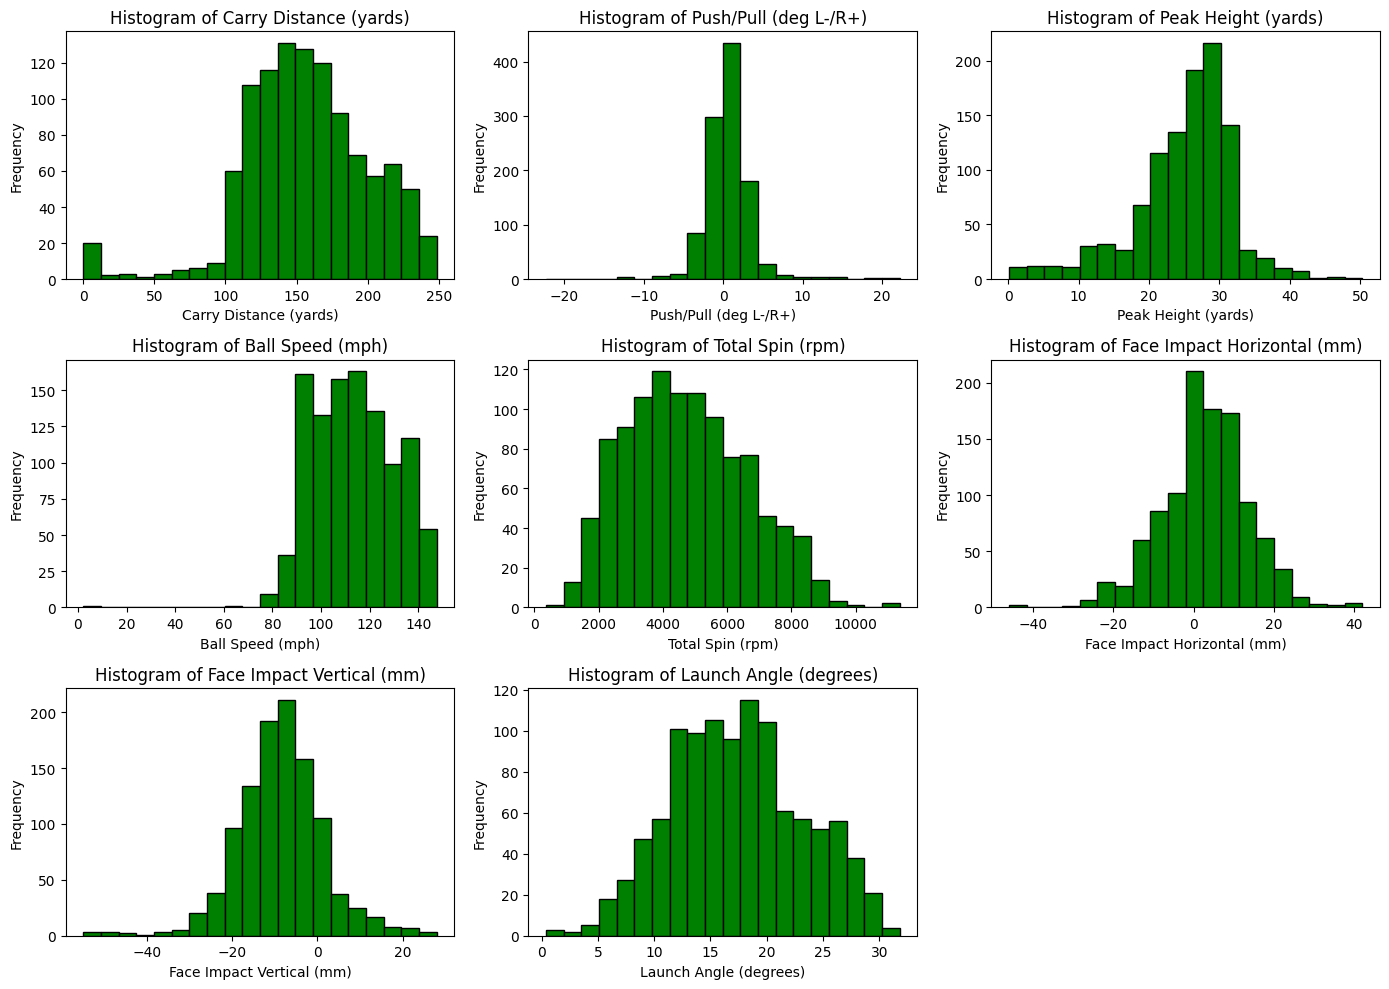

In [14]:
metrics = {
    "Carry (yds)": "Carry Distance (yards)",
    "Push/Pull (deg L-/R+)": "Push/Pull (deg L-/R+)",
    "Peak Height (yds)": "Peak Height (yards)",
    "Ball Speed (mph)": "Ball Speed (mph)",
    "Total Spin (rpm)": "Total Spin (rpm)",
    "Face Impact Horizontal (mm toe-/heel+)": "Face Impact Horizontal (mm)",
    "Face Impact Vertical (mm low-/high+)": "Face Impact Vertical (mm)",
    "Launch Angle (deg)": "Launch Angle (degrees)"
}

# Plot histograms
plt.figure(figsize=(14, 10))
for i, (col, label) in enumerate(metrics.items(), 1):
    plt.subplot(3, 3, i)
    plt.hist(clean_data[col], bins=20, edgecolor='black', color = 'green')
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {label}")

plt.tight_layout()
plt.show()

Checking out the histograms of 8 of our metrics we can see that they are pretty well distributed. In carry, we see that most of our shots carried over 100 yds with the majority around the 150 mark. We also can see a small spike around 0 as some really poorly struck shots can unfortunately end up there. But that just shows that this data is real and includes all kinds of shots.

In our push/pull histogram we see that the majority of shots were pulled while a good amount were pushed too. This could be due to different clubs, different days, no swing is exactly the same as the last, so I'm not surprised to see both pushes and pulls.

Peak height looks pretty good too. we see that most shots get at least 20 yds in the air with the majority around 30 or so. Again you can see the shots that were really poorly hit as they probably didn't get too high off the ground.

Ball speed is up next and we see that the large majority of our shots exceeded the 80 mph mark for this metric. while the highest can exceed 140. This is quite a large difference but it makes sense as different clubs will produce different ball speeds. 

Total Spin seems to be fair well distributed with most shots ~4000 rpm. Like most other metrics, spin will differ between the clubs with lower spin being more common in the longer clubs like driver, 3w, etc. 

Face Impact Horizontal/Vertical I definitely wanted to show these two as they are big indicators or well struck shots. While they are not the end all be all, they are very important. I know in my few months of testing that I have begun to miss more towards the toe but looking at the histogram we can see that most of the time i was missing heel. If I did not include the last 5 or so sessions I think we would see almost all the shots miss to the heel rather than the toe, but here we have good distribution. For the vertical impact we see that almost all strikes were low. I did notice this in my testing that even shots i though were very well hit still saw low impacts. This could be due to the positioning of the stickers on the face so I might have to move those around in the future. 

Finally we have Launch Angle which seems to be well distributed around the different types of clubs that we have used so im not surprised this was well recorded. 


Next lets check for any correlation between our features. We expect things like carry and total distance to be highly correlated. Also things like club speed and ball speed, club speed and carry and a few others, so lets make a correlation matrix. 

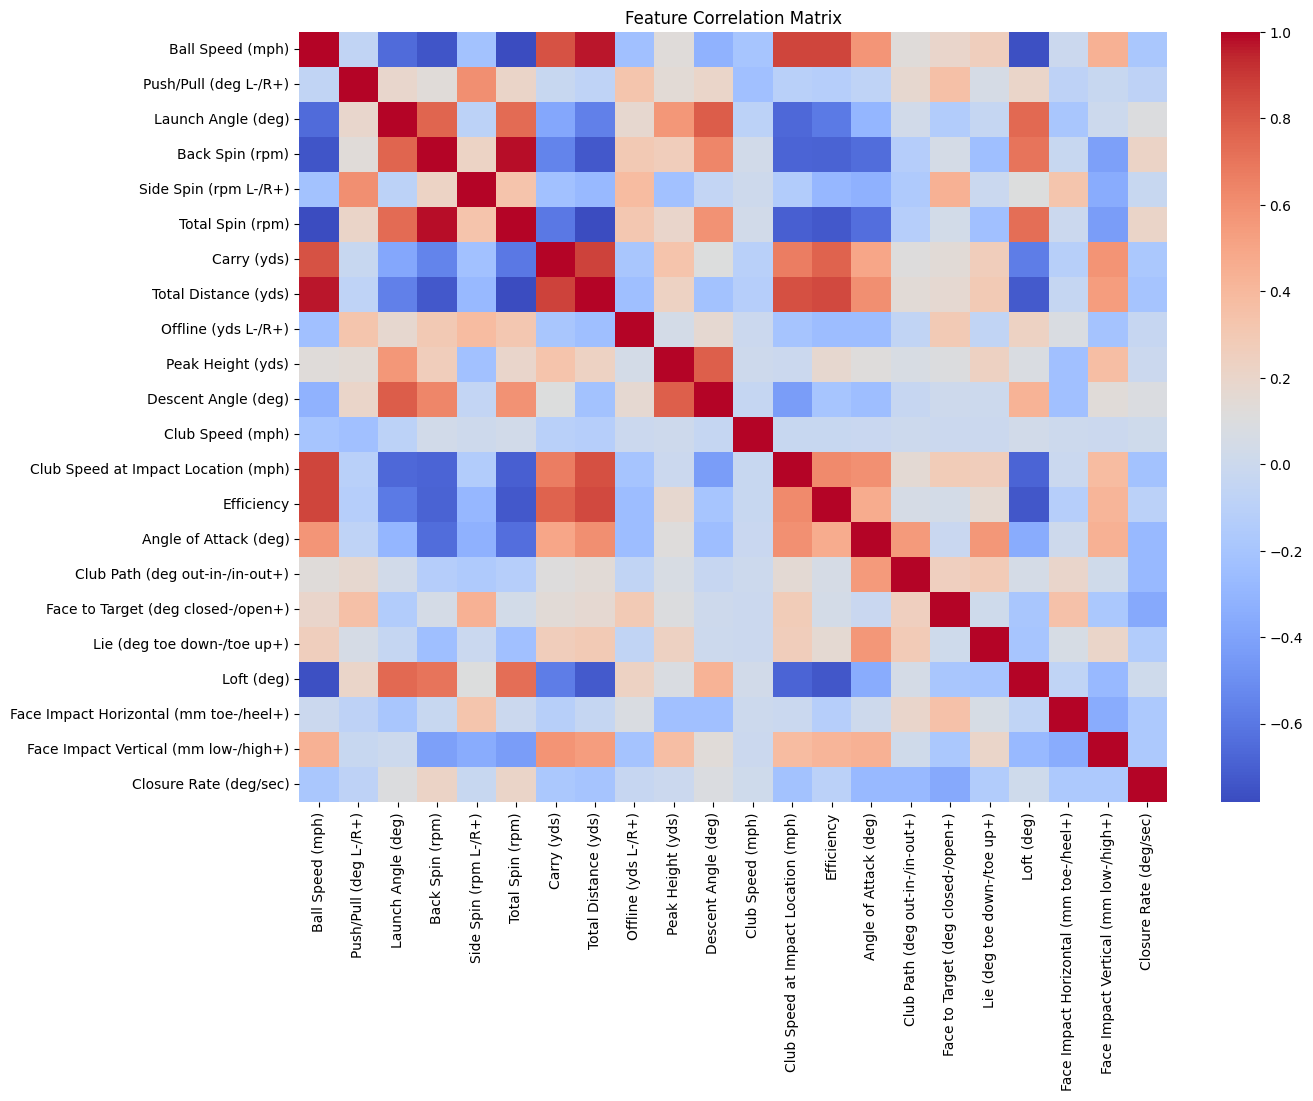

In [15]:
plt.figure(figsize=(14,10))
numeric_cols = clean_data.select_dtypes(include=['float64', 'int64']).columns
corr = clean_data[numeric_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Matrix")
plt.show()

Upon reviewing the correlation matrix, we observe a mix of positive and negative relationships between the various swing metrics. One of the most intuitive findings is the strong positive correlation between Ball Speed and both Carry Distance and Total Distance — as expected, faster ball speeds generally result in longer shots.

An interesting distinction emerges between the two club speed metrics. Club Speed shows little to no correlation with most other variables, while Club Speed at Impact Location demonstrates meaningful positive correlations with Ball Speed and distance metrics, and negative correlations with Launch Angle, Spin Rates, and Loft. Although these two club speed variables are numerically close, their differing relationships suggest that impact speed may better reflect the quality of energy transfer to the ball.

As anticipated, Loft is negatively correlated with Ball Speed, Distance, and Efficiency — higher loft typically results in higher launch and spin, but shorter, slower shots. This is also reflected in its positive correlation with Launch Angle and spin-related metrics.

Overall, the correlations are logical and consistent with golf physics. These findings help highlight which features may be most informative in future dimensionality reduction and clustering steps.



Before applying any unsupervised learning techniques such as Principal Component Analysis (PCA) or K-means clustering, it is important to assess whether the data needs to be transformed. These methods are particularly sensitive to the scale of the input features. For example, PCA aims to capture the directions of maximum variance in the data, and if some features have much larger ranges than others, they will dominate the principal components. Similarly, K-means clustering uses Euclidean distances to form clusters, and variables with larger numerical ranges can distort these distance calculations, leading to biased clustering results.

In this dataset, we have a diverse set of features representing different physical measurements—such as speeds (mph), distances (yards), spin rates (rpm), angles (degrees), and impact positions (millimeters). These features are on vastly different scales, and as a result, scaling is necessary. To address this, we plan to use Z-score standardization, which transforms each feature to have a mean of 0 and a standard deviation of 1. This ensures that each feature contributes equally during PCA and clustering.

We also considered whether log transformation might be appropriate for any of the variables. Log transformations are often useful when data is positively skewed or when reducing the influence of large outliers is important. After examining the distributions of several key metrics, we found that although a few (like spin rates or closure rate) showed mild right skewness, none exhibited the type of extreme skew or long-tailed distribution that would clearly benefit from a log transformation. Furthermore, many of these features are more intuitively interpreted in their original form, which supports our decision to retain their natural scale.

Therefore, we have determined that standardization is necessary and sufficient for our purposes. No log transformation or other nonlinear transformation will be applied prior to modeling.

In [16]:
X = clean_data.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

This completes the Exploratory Data Analysis (EDA) portion of the project. We thoroughly cleaned and inspected the dataset, addressing issues like duplicate shot numbers, mislabeled clubs, and missing values. Key features such as ball speed, carry distance, and efficiency were explored through visualizations and correlation analysis, providing insight into the relationships within the data.


PRINCIPAL COMPONENT ANALYSIS (PCA)
Next, we move into the analysis phase using unsupervised learning techniques. We’ll begin with Principal Component Analysis (PCA) to reduce dimensionality while preserving key variation in the data. Then, we’ll apply K-Means Clustering to group similar shots based on performance metrics. Our goal is to identify patterns—such as pure strikes, mishits, or high-spin shots—and gain insights into swing tendencies across different clubs.



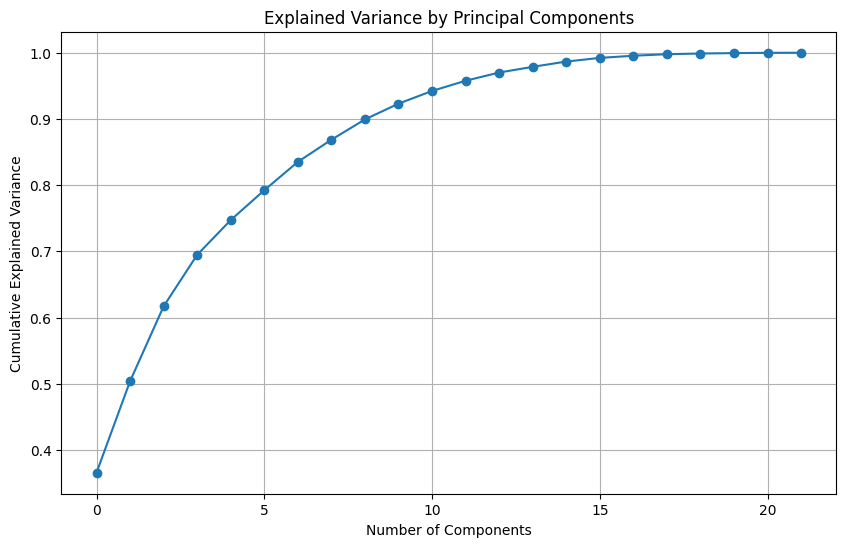

In [17]:
pca = PCA()
pca_components = pca.fit_transform(X_scaled)

# Plot explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

To reduce the complexity of our dataset while retaining most of the meaningful variance, we applied Principal Component Analysis (PCA). The scree plot of cumulative explained variance revealed a couple things.

The first principal component alone explains around 35% of the total variance.

By the eighth component, we have captured approximately 90% of the total variance.

Beyond 10–12 components, the curve flattens, indicating diminishing returns in explained variance.

Based on these observations, we have chosen to retain 8 principal components. This allows us to reduce our original 22-feature dataset into a lower-dimensional representation while preserving most of the variance and structure. This reduction will help improve the performance and interpretability of downstream unsupervised learning methods, especially clustering.

Using PCA in this way helps us eliminate redundant or less informative features and focus on the underlying structure in the data. We will now proceed to apply clustering techniques such as K-means on this reduced dataset to discover meaningful groupings among our golf shots.

So lets take a look at what our 8 PCA loadings are made of. 

In [18]:
pca_8 = PCA(n_components=8)
pca_8.fit(X_scaled)


loadings = pd.DataFrame(
    pca_8.components_.T,
    columns=[f'PC{i+1}' for i in range(8)],
    index=clean_data.columns
)

print(loadings)

                                             PC1       PC2       PC3  \
Ball Speed (mph)                        0.330291  0.049127  0.086731   
Push/Pull (deg L-/R+)                  -0.065100  0.058214  0.431603   
Launch Angle (deg)                     -0.257388  0.359080  0.018060   
Back Spin (rpm)                        -0.315287  0.129539  0.064185   
Side Spin (rpm L-/R+)                  -0.107749 -0.241481  0.394817   
Total Spin (rpm)                       -0.324151  0.089950  0.087914   
Carry (yds)                             0.274859  0.228164  0.096707   
Total Distance (yds)                    0.327773  0.117509  0.075931   
Offline (yds L-/R+)                    -0.120459 -0.038950  0.303508   
Peak Height (yds)                      -0.004963  0.506908  0.130463   
Descent Angle (deg)                    -0.160519  0.456808  0.100828   
Club Speed (mph)                       -0.020978 -0.053731 -0.100302   
Club Speed at Impact Location (mph)     0.303005 -0.028337  0.09

We analyzed the PCA loadings of the first 8 principal components (PCs), which capture most of the variance in the dataset. Each PC is influenced by a combination of original features (metrics), and we interpreted what each component likely represents based on its strongest loadings:

| **PC**  | **Focus**                 | **Top Influential Metrics**                         | **Interpretation Summary**                            |
| ------- | ------------------------- | --------------------------------------------------- | ----------------------------------------------------- |
| **PC1** | Power vs Spin             | Ball Speed, Carry, Club Speed at Impact, Spin, Loft | Trade-off between distance efficiency and spin-loft   |
| **PC2** | Trajectory Shape          | Peak Height, Descent Angle, Launch Angle, Side Spin | High, steep shots vs low, spin-heavy shots            |
| **PC3** | Directional Control       | Face to Target, Push/Pull, Side Spin, Offline       | Misalignment, face angle, and directional deviation   |
| **PC4** | Club Delivery             | Club Path, Angle of Attack, Lie, Loft               | Club movement and angle during impact                 |
| **PC5** | Speed & Face Control      | Club Speed, Face Impact Horizontal, Face to Target  | Clubhead speed and how the face is delivered          |
| **PC6** | Strike Consistency        | Club Speed, Side Spin, Lie, Impact Location         | Consistency and quality of strike                     |
| **PC7** | Face Closure & Lie Angle  | Closure Rate, Lie, Impact Location                  | Clubface rotation at impact and shot orientation      |
| **PC8** | Club Path & Closure Blend | Club Path, Closure Rate, Lie                        | Interaction of club path, closure, and swing dynamics |


KMEANS CLUSTERING

Okay now that we have determined the influential metrics and given a summary on each PC, we can now move onto K-means Clustering using our newly transformed data. 

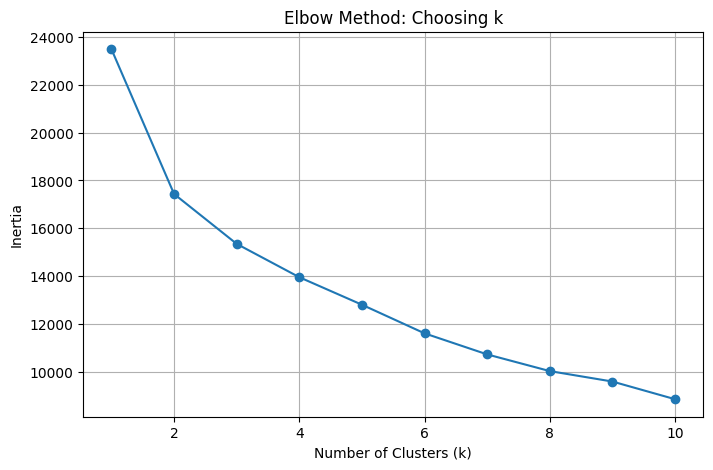

In [19]:
inertia = []


for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_components)  # <-- Use your PCA-transformed data here
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method: Choosing k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

Here we are using the elbow method to pick the right number of clusters. If we choose too few clusters we risk underfitting and missing patterns. However if we choose too many clusters we can overfit and capture noise.
Analyzing our elbow method we see a sharp drop in interia when we have 1 cluster to when we have 2. We continue a downward trend as number of clusters increase but not as sharply. We want to find the sweet spot where adding a cluster doesn't descrease inertia too much. I believe that spot is either 4 or 5 clusters. I think we will choose 5 clusters. Let's continue with K-means clustering.

In [20]:
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(pca_components[:, :8]) 
golf_data['Cluster'] = cluster_labels


In [21]:
print(golf_data['Cluster'].value_counts().sort_index())


golf_data[['Club Name', 'Carry (yds)', 'Ball Speed (mph)', 'Cluster']].head()

Cluster
0     65
1    114
2    246
3    311
4    332
Name: count, dtype: int64


,Club Name,Carry (yds),Ball Speed (mph),Cluster
0,7i,153.7,111.8,4
1,7i,153.7,111.8,4
2,7i,153.1,109.6,4
3,7i,147.9,107.4,4
4,7i,157.3,114.1,4


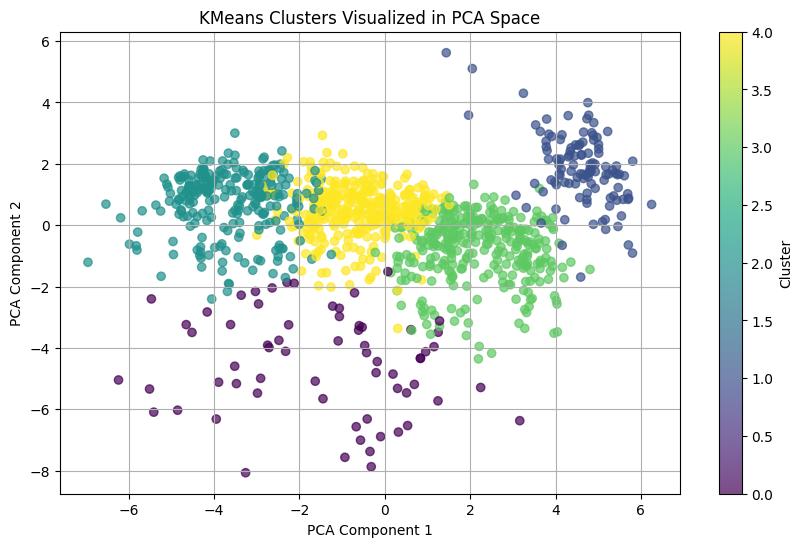

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters Visualized in PCA Space')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

In [23]:
summary_data = golf_data.drop(columns=['Shot Number', 'zero_count'])
cluster_summary = summary_data.groupby('Cluster').mean(numeric_only=True)
print(cluster_summary)

         Ball Speed (mph)  Push/Pull (deg L-/R+)  Launch Angle (deg)  \
Cluster                                                                
0               97.981538               1.899518           10.767317   
1              137.520175               0.845055           15.314912   
2               94.512602               1.337495           24.961789   
3              126.060450               0.091116           11.927974   
4              109.459639               0.380013           18.861145   

         Back Spin (rpm)  Side Spin (rpm L-/R+)  Total Spin (rpm)  \
Cluster                                                             
0            3983.243312            1519.775945       4745.077588   
1            2428.043860            -344.421053       2517.982456   
2            7171.707317             166.929181       7204.821138   
3            3276.237942             -30.907675       3338.704180   
4            4967.355422             -91.700316       5000.924699   

         Ca

In [24]:
club_dist = golf_data.groupby(['Cluster', 'Club Name']).size().unstack().fillna(0)
print(club_dist)

Club Name     3w     4h    5i    6i     7i    8i    9i     Dr     PW
Cluster                                                             
0           11.0    4.0  12.0   6.0   13.0   1.0   8.0    0.0   10.0
1            1.0    0.0   0.0   0.0    0.0   0.0   0.0  113.0    0.0
2            0.0    0.0   0.0   0.0    5.0  34.0  95.0    0.0  112.0
3          100.0  110.0  82.0  17.0    0.0   0.0   0.0    2.0    0.0
4            0.0    2.0  26.0  97.0  102.0  85.0  19.0    0.0    1.0


KMEANS CLUSTERING ANALYSIS
What can we take away from all this? What does each cluster represent? Lets go through the clusters one by one.

Cluster 0: The purple cluster that is quite spread out. This is likely all my poorly hit shots and mishits. In this cluster we see the pretty low ball speeds and very low average carry distance.  This all suggests off center strikes, this is suppsorted by an average of almost 16mm on the heel and 25mm on the low side (very poor strikes!). 

Cluster 1: The dark blue cluster that is situated in the  upper right section of our visualization. Through out every single metic I could look at this and can tell immediately that these are values matching my driver. This checks out as the cluster is over 99% driver shots. 

Cluster 2: The teal cluster in the upper left. Most of our shot in this cluster come from our highest listed clubs, the PW, 9I, 8I, and even a few 7I. With these clubs we should see the highest spin numbers and a short to low/mid avg on carry. The carry distance for this cluster is pretty much spot on for this group of clubs. We also see the highest launch angle in this cluster by quite a margin which makes sense considering our high spin numbers. 

Cluster 3: The green cluster. Here we see that this cluster is mostly our longer clubs (minus driver). I expect to see ball speeds a little below driver levels, spin to be the second lowest and the carry to be second highest. These are the clubs that can hit fairly far, but due to this we see decreased spin and increased ball/club speeds.

Cluster 4: Yellow cluster in the middle of our clusters. This is comprised mostly of our mid irons as we see the large majority of this cluster perfectly between the teal cluster that was our irons like PW and 9, and our low iron/hybrid/wood cluster in the green. All of the values we expect fall right in between these two groups and it fits perfectly to our mid irons(6,7,8).

So what does all this mean? As a golfer using this tool to try and figure out where I need to work on my game the most, how can I analyze this and turn it into something meaninful? Well lets go club by club and see how we performed.

Driver: Driver swings are very distinct and are easily distinguished. That being said, all of the driver shots were in their own cluster. Its good that no driver swings were placed in other clusters.

3 Wood: Here is where we start to see some interesting patterns. Most of the 3w shots fall into cluster #3. In this cluster as we stated earlier mainly contained longer clubs as they had similar traits. However we do see that 11 of the 112 shots with this club fell into cluster #0. Thats not good since that cluster was said to be our cluster that contained most of our mishits/really poorly hit shots. So we know that there is a little room for improvement with this club. But on the plus side we did see 1 single 3w shot that got roped into cluster #1 so I must  have hit that shot really well for it to get into that cluster. 

4 Hybrid: Very similar to the 3w. Most shots fall into cluster #3, but we only see 4 mishits from this club, and only 2 shots that fell into cluster #4 which is our mid iron cluster so to speak. Overall this is a very well performing club for me.

5 Iron: One of our more interesting results. Here we can conclude that while most of these shots ended up in a cluster that is suited for this club, we do have a fairly decent amount of shots that did not. 26 of them fell into the mid iron cluster, adn 12 were mishit. This tells us that this club while most of the time is hit well, is definitely one that we need to practice more and give more attention to!

6 Iron: This club is one of our more consistent ones in the bag. Most shots are in cluster #4 the mid iron clsuter right where this club should be! While we do have the occasional mishit, we have even more shots that were hit well enough to be placed into cluster 3 with the longer clubs like 5I and 4h! Like 4h this club is one of my better ones.

7 Iron: This club works pretty well for me only 18 of the 120 fall outside cluster #4. With 5 shots falling into cluster #2 withthe more lofted clubs and 13 into our mishit cluster. There is definitely improvements to be made her but for the most part we hit this club just fine

8 Iron: Here we see most shots in the mid iron cluster with about 1/3 of the shots falling to cluster #2. Only 1 mishit from this club, but more consistency is definitely needed to lower the amount of shots in cluster #2.

9 Iron: This club is quite similar to the 6i as the majority of shots are correctly clustered into cluster #2. With a couple mishits, and even more shots that were hit well enough to get into the mid iron cluster. We can definitely improve on mishits but when it goes well, it goes really well.

Pitching Wedge: Most shots are right where we expect them. However we do see a double digit number for mishits. For such a shot club I would definitely like to see that number much lower. Something to work on for sure!



HIERARCHICAL CLUSTERING



Overall this unsupervised Machine Learning method worked well in showing us where I am strong and where I need to make improvements in my golf clubs. We were able to turn a bunch of numbers into actionable patterns! Let's look now at hierarchical clustering so we can compare the two methods.

In [25]:
X_pca_8 = pca_components[:, :8]

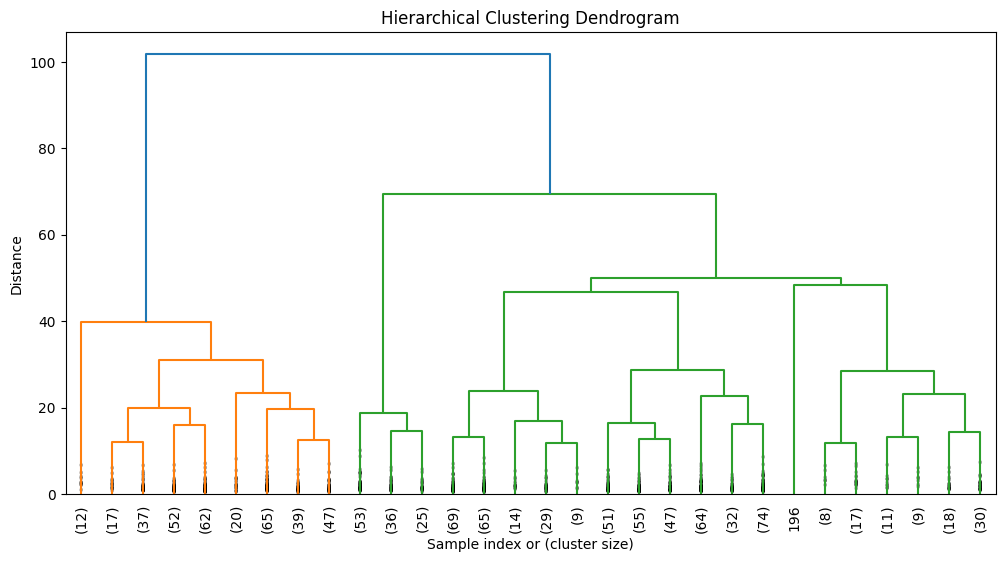

In [36]:


linked = linkage(X_pca_8, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked,
           truncate_mode='lastp'
           p=30,                   
           leaf_rotation=90.,
           leaf_font_size=10.,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or (cluster size)')
plt.ylabel('Distance')
plt.show()


In [27]:
from scipy.cluster.hierarchy import fcluster

n_clusters = 5
h_cluster_labels = fcluster(linked, n_clusters, criterion='maxclust')

In [29]:
clean_data['h_cluster'] = h_cluster_labels
clean_data.groupby('h_cluster').mean()

,Ball Speed (mph),Push/Pull (deg L-/R+),Launch Angle (deg),Back Spin (rpm),Side Spin (rpm L-/R+),Total Spin (rpm),Carry (yds),Total Distance (yds),Offline (yds L-/R+),Peak Height (yds),Descent Angle (deg),Club Speed (mph),Club Speed at Impact Location (mph),Efficiency,Angle of Attack (deg),Club Path (deg out-in-/in-out+),Face to Target (deg closed-/open+),Lie (deg toe down-/toe up+),Loft (deg),Face Impact Horizontal (mm toe-/heel+),Face Impact Vertical (mm low-/high+),Closure Rate (deg/sec)
h_cluster,,,,,,,,,,,,,,,,,,,,,,
1,96.792023,1.817444,23.003919,6652.464387,382.593856,6784.421652,124.482621,134.408262,14.158737,25.841847,45.922244,7.997635e+01,80.063810,1.210057,-3.769516,1.978464,0.557762,1.341760,34.651316,3.942016,-13.154709,2155.346937
2,137.520175,0.779266,15.310526,2431.184211,-348.394737,2521.929825,223.030702,244.347368,-13.107018,31.603509,38.928070,9.718772e+01,96.884211,1.415263,4.305263,3.309649,1.156694,5.993860,19.296491,1.475279,5.915153,1873.965789
3,119.194499,0.286055,15.380943,4078.795678,-56.712490,4116.176817,174.126130,190.162475,-0.583050,25.330452,39.860118,8.631336e+01,86.702019,1.378664,-2.199749,1.463989,0.093075,1.163307,23.166700,1.065606,-7.464393,2162.255513
4,113.097849,-1.577757,9.772043,2937.840189,-58.600657,3181.311137,109.666667,162.645161,-6.990323,11.551613,18.187097,8.752151e+01,88.132516,1.295484,-0.819236,1.958114,-0.363160,1.423114,24.526647,8.916951,-16.827508,1970.737939
5,2.200000,-22.300000,0.400000,6523.677686,272.297521,6682.107438,0.100000,0.600000,-0.200000,26.567769,26.700000,3.402782e+38,79.650000,1.218843,-3.755372,1.870588,-0.527586,1.503390,34.472500,3.607143,-11.546218,2301.297500


In [33]:
golf_data['h_cluster'] = clean_data['h_cluster']  # assuming row order is still aligned
h_cluster_summary = golf_data.drop(columns=['Shot Number', 'zero_count']).groupby('h_cluster').mean(numeric_only=True)
print(h_cluster_summary)

           Ball Speed (mph)  Push/Pull (deg L-/R+)  Launch Angle (deg)  \
h_cluster                                                                
1                 96.792023               1.817444           23.003919   
2                137.520175               0.779266           15.310526   
3                119.194499               0.286055           15.380943   
4                113.097849              -1.577757            9.772043   
5                  2.200000             -22.300000            0.400000   

           Back Spin (rpm)  Side Spin (rpm L-/R+)  Total Spin (rpm)  \
h_cluster                                                             
1              6652.464387             382.593856       6784.421652   
2              2431.184211            -348.394737       2521.929825   
3              4078.795678             -56.712490       4116.176817   
4              2937.840189             -58.600657       3181.311137   
5              6523.677686             272.297521      

In [37]:
club_dist_hier = golf_data.groupby(['h_cluster', 'Club Name']).size().unstack().fillna(0)
print(club_dist_hier)

Club Name    3w    4h    5i     6i    7i    8i     9i     Dr     PW
h_cluster                                                          
1           0.0   0.0   3.0    4.0  40.0  71.0  112.0    0.0  121.0
2           0.0   1.0   0.0    0.0   0.0   0.0    0.0  113.0    0.0
3          77.0  94.0  98.0  108.0  73.0  49.0    7.0    2.0    1.0
4          35.0  21.0  19.0    8.0   7.0   0.0    2.0    0.0    1.0
5           0.0   0.0   0.0    0.0   0.0   0.0    1.0    0.0    0.0


HIERARCHICAL ANALYSIS + COMPARISON TO KMEANS
After all of our hierarchical clustering we come to our analysis. Once again we have 5 clusters exactly like KMeans clustering. But here we see that in cluster 5 wither is only 1 single shot and its numbers are so vastly different and inconsistent that im going to just thow this one out since it offers no real benefits.

Cluster 1 is comprised of our lofted irons and even some of out mid irons (and a couple 5i's). We do see fewer numbers of shots as the clubs get longer. The majority of 8 Irons seem to be here but there is a large chunk in the next cluster. But we can pretty safely say that this cluster is our lofted/short iron shots.

Cluster 2 is pretty much all our driver shots. This is almost exactly what we saw in our Kmeans clusters. 

Cluster 3 is a mix of long clubs and mid irons. This cluster seems broad as it has so many clubs in it. mostly our mid/low irons, but also a majority of our 4 Hybrid and 3 Wood shots. This seems to be a blend of two clusters we saw in Kmeans.

Cluster 4 is a smaller cluster, but mainly is home to longer clubs like 3 wood 4h and 5I. This is almost like what we saw in Kmeans as these clubs were mostly grouped togther but the maority of the shots for each of these clubs lies in cluster 3. This cluster saw very low carry and total distance averages for the club types. I think that this cluster may indicate shots that were mishit with longer clubs. Though we do see a few outliers like a couple 9i and PW shots, but I think these shots were mislabeled due to thier carry distance. 

CONCLUSION

This project's goal was to identify unseen patterns in a dataset that I created using my own golf shots. I wanted to identify any potential areas of my game that via methods like PCA, Kmeans, and Hieracrchical clustering, showed I could identify and focus my attention to, almost like a virtual coach. In our Kmeans we seperated all the shots into 5 clusters and i was able to see clearly what clubs were consistent, which ones were not. This was really insightful to me as i was able to see how many shots were placed inot the clusters they should be, and how many were really poorly hit and how many were hit better or worse than average. 

In hierarchical clustering we also came away with 5 clusters, but were only really able to use 4. While similar to kmeans, with only 4 meaningful clusters my analysis was not as thorough as i would have liked. We did see some very similar trends to kmeans. I think using the two methods and comparing can definitely result in some meaningful results, individually I thought Kmeans was a much more effective tool. 